# Загрузка аннотаций
Здесь откройте файл с аннотациями и считайте все данные

Формат аннотаций:

имя_файла upper_face_corner_x upper_face_corner_y bottom_face_corner_x bottom_face_corner_y left_eye_x left_eye_y right_eye_x right_eye_y nose_x nose_y left_mouth_x left_mouth_y right_mouth_x right_mouth_y

Координаты левого верхнего и правого нижнего углов описывающего прямоугольника заданы относительно изображения. Координаты лэндмарок - относительно описывающего прямоугольника

In [4]:
import numpy as np
def load_annotations():
    annotations = np.loadtxt('annotations.txt', dtype='str')
    return annotations

annotations = load_annotations()

# Отображение изображений
Здесь загрузите и отобразите все изображения. Рекомендуется использовать реализованный метод отображения.

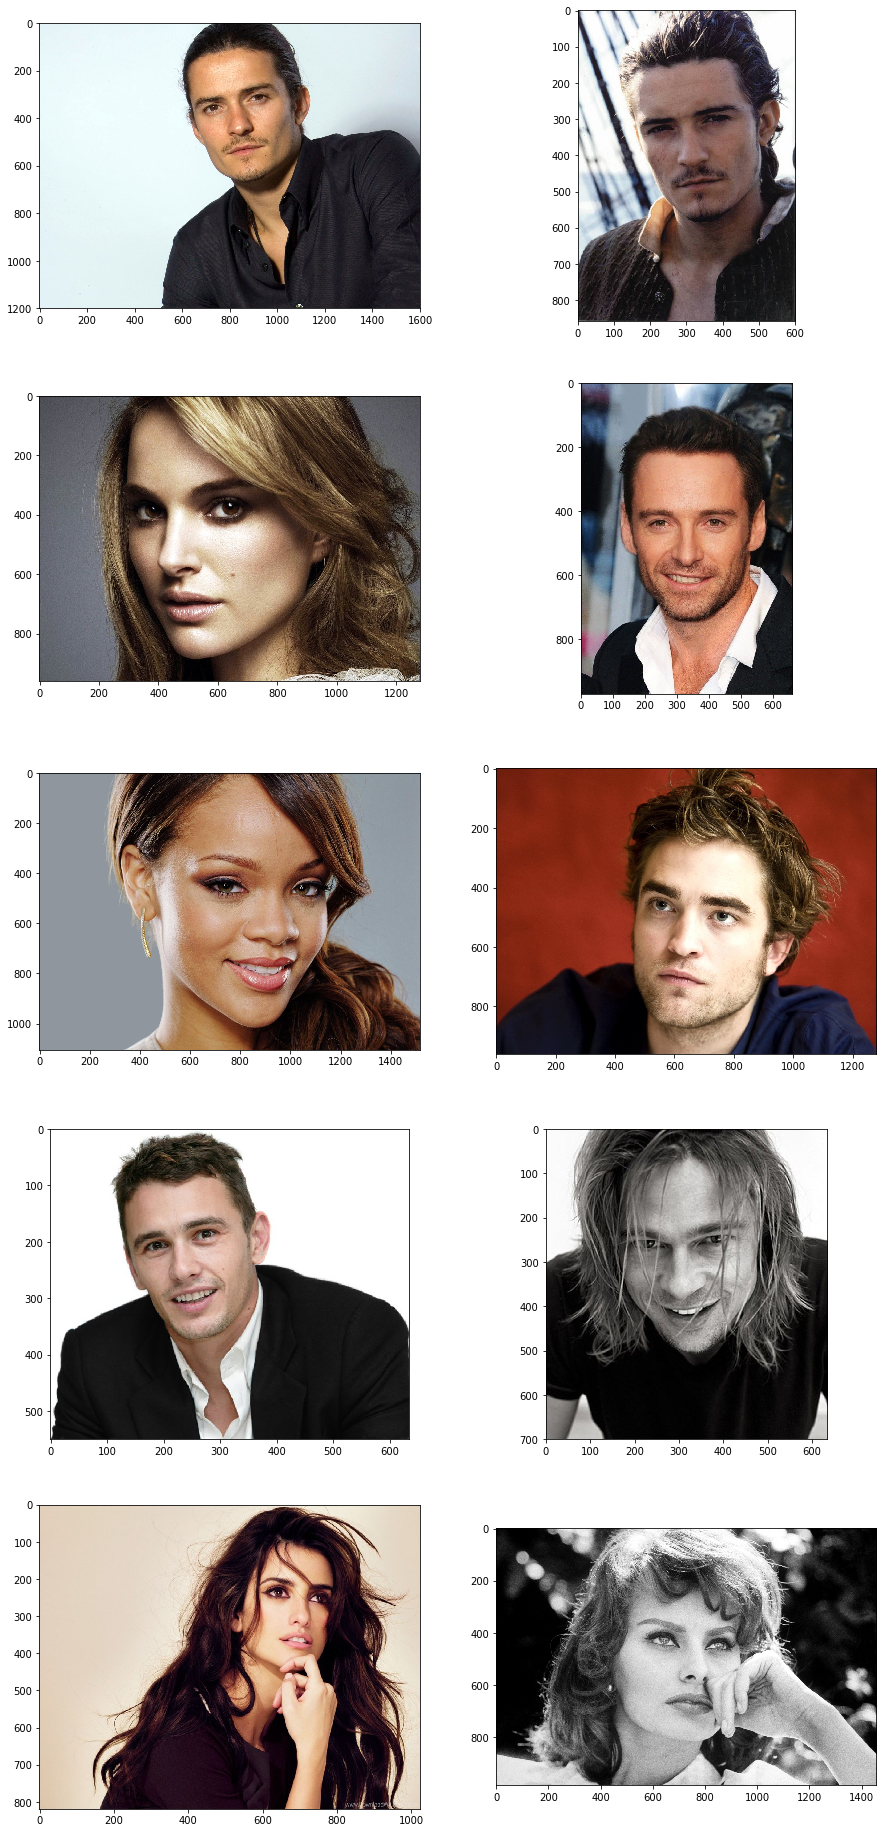

In [6]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline  

def load_images(annotations):
    images = []
    for image_name in annotations[:, 0]:
        images.append(cv2.imread('images\\' + image_name))
    return images


def show_images(images):
    '''
    Функция для ин-лайн отображения изображений
    Входные параметры:
    images: numpy uint8 массив изображений в формате BGR
    '''
    columns = 2
    images_count = len(images)
    plt.figure(figsize=(15,40))
    
    for i, image in enumerate(images):
        plt.subplot(images_count / columns + 1, columns, i + 1)
        image = image/255.
        plt.imshow(image[:,:,::-1])
    
images = load_images(annotations)

show_images(images)


# Отображение рамок лиц и лэндмарок
Здесь отобразите изображения с нарисованными рамками и лэндмарками

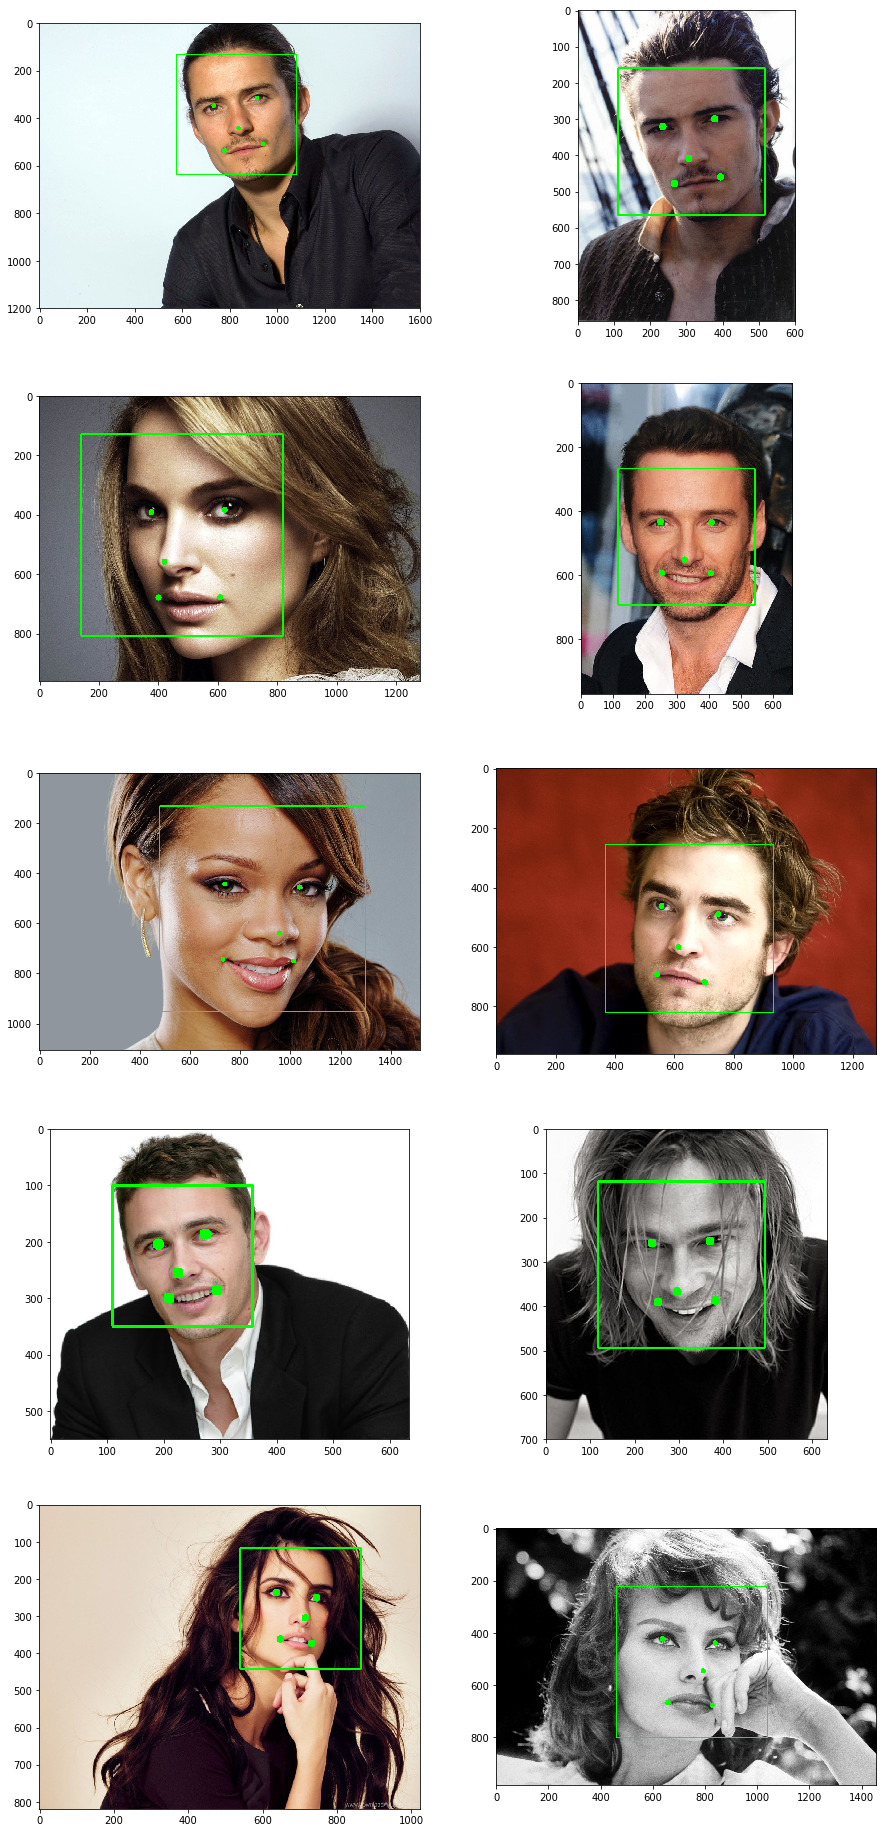

In [28]:

def get_image_cords(image, annotation, annotation_offset):
    return (int(float(annotation[annotation_offset]) * image.shape[1]), 
           int(float(annotation[annotation_offset + 1]) * image.shape[0]))


def get_rectangle_cords(x, y, w, h, annotation, annotation_offset):
    return (int(float(annotation[annotation_offset]) * w) + x, 
            int(float(annotation[annotation_offset + 1]) * h) + y)


def draw_all_and_show_images(annotations):
    images = load_images(annotations)
    for i, image in enumerate(images):
        annotation = annotations[i]
        upper = get_image_cords(image, annotation, 1)
        bottom = get_image_cords(image, annotation, 3)
        points = []
        for i in range(5, 15, 2):
             point = get_rectangle_cords(upper[0], upper[1], bottom[0] - upper[0], bottom[1] - upper[1], annotation, i)
             points.append(point)
        for point in points:
            cv2.circle(image, point, 10, (0, 255, 0), -1)
        cv2.rectangle(image, upper, bottom, (0, 255, 0), 3)
    show_images(images)


draw_all_and_show_images(annotations)


# Подгон размера очков
Подгон размера очков к размеру фотомодели

In [29]:
#http://benjamintan.io/blog/2018/05/24/making-transparent-backgrounds-with-numpy-and-opencv-in-python/
glasses = cv2.imread('glasses.png')
glasses = cv2.cvtColor(glasses, cv2.COLOR_BGR2RGBA)
glasses = cv2.resize(glasses, None, fx = 0.27, fy = 0.265)
M = np.float32([[1, 0, 355], [0,1,520]])
glasses = cv2.warpAffine(glasses, M, (1200, 1319), borderMode=1)
glasses[np.all(glasses == [255, 255, 255, 255], axis=2)] = [0, 0, 0, 0]


# Наложение модели очков
Здесь реализуйте автоматическое наложение очков на лица на основании ключевых точек (лэндмарок) и отобразите

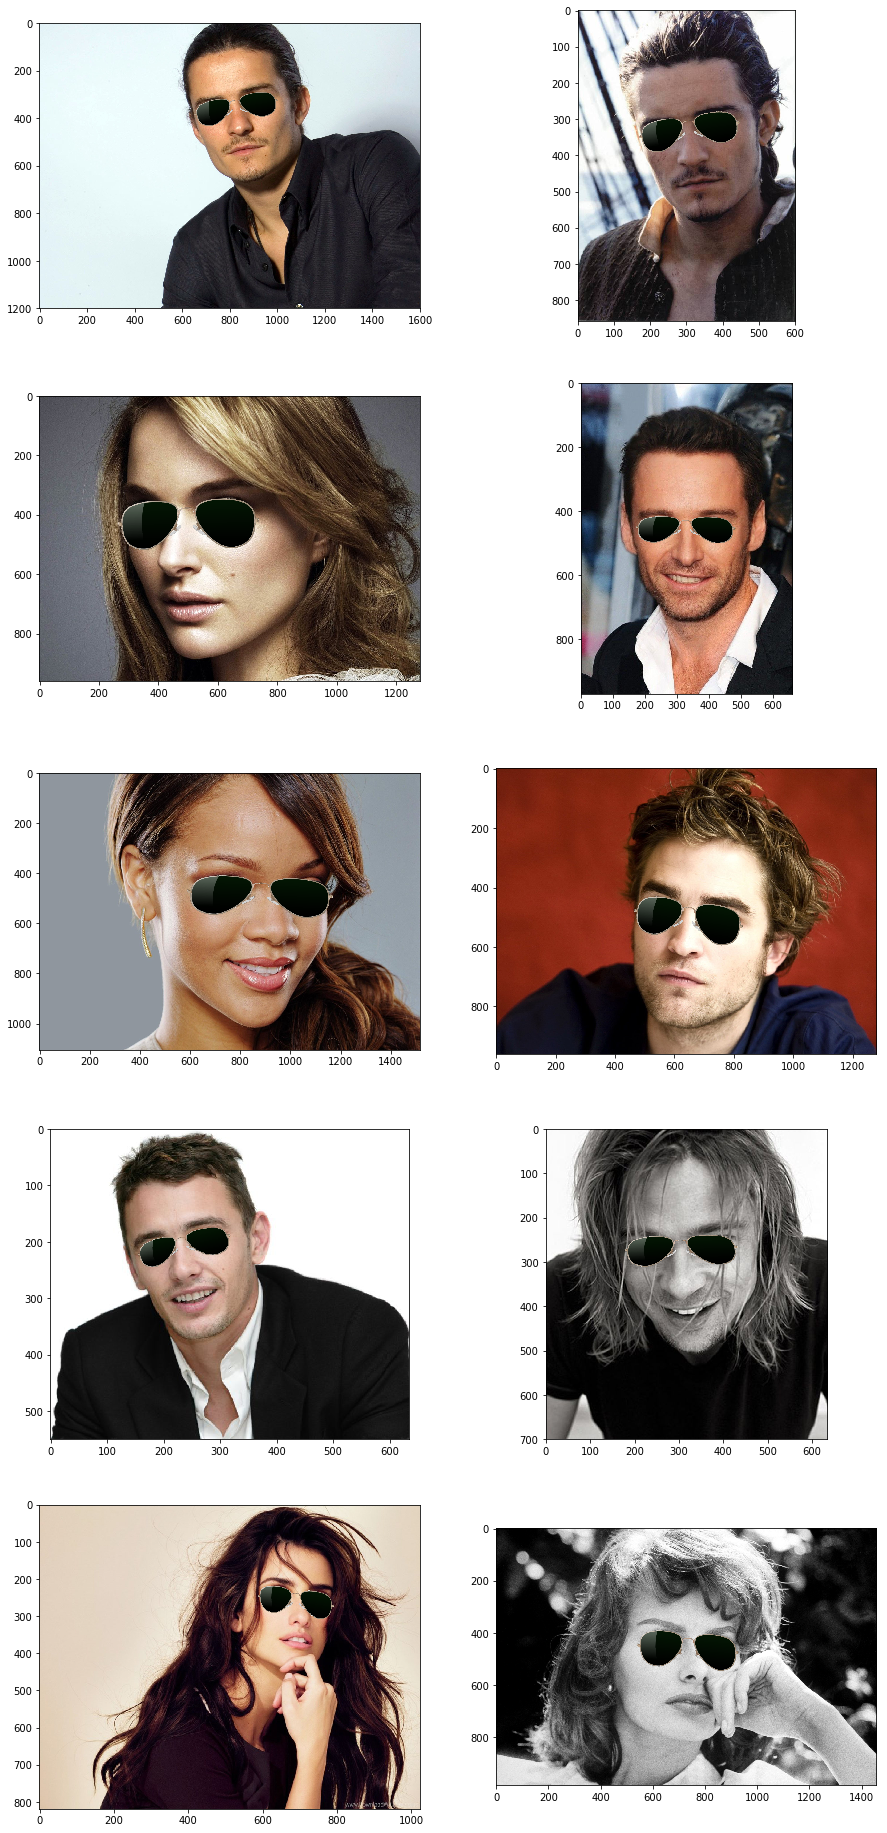

In [30]:

# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
def add_glasses_and_show_images():
    images = load_images(annotations)
    results = []
    for i, image in enumerate(images):
        annotation = annotations[i]
        upper = get_image_cords(image, annotation, 1)
        bottom = get_image_cords(image, annotation, 3)
        points = []
        for i in range(5, 15, 2):
             point = get_rectangle_cords(upper[0], upper[1], bottom[0] - upper[0], bottom[1] - upper[1], annotation, i)
             points.append(point)
        points = np.float32(points)
        points = np.delete(points,2,0) # удаление носа
        origin_points = np.float32([[485, 580], [745, 580], [515, 880], [715, 880]]) # размечено на "эталонном" фото
        matrix = cv2.getPerspectiveTransform(origin_points, points)
        w,h,c = image.shape #тут
        ready_glasses = cv2.warpPerspective(glasses, matrix, (h,w), borderMode=1)
        alpha_s = ready_glasses[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s
        result = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
        for c in range(0, 3):
            result[:,:, c] = (alpha_s * ready_glasses[:, :, c] + alpha_l * result[:, :, c])
        result = cv2.cvtColor(result, cv2.COLOR_RGBA2BGR)
        results.append(result)
    
    show_images(results)
    
    
add_glasses_and_show_images()